In [2]:
import pandas
import os
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from scipy.io import savemat, loadmat
from nilearn import datasets, image, plotting, input_data
from statsmodels.sandbox.stats.multicomp import multipletests

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Get hippocampus samples

In [4]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
#df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [312]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Run main analysis pipeline

In [5]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'separate')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.6758859774821839
running final model
final model fit r2 =  0.8768105093258032
running sanity_check


# HAGS Index across the brain

In [7]:
# GET GENE EXPRESSION FOR HIPPOCAMPAL SAMPLES 
# (loading this df takes awhile and may not work on computers without lots of memory 
# (its about 60k x 4k)
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

#### Get HAGS index for all tissue sample across the brain

In [13]:
gcx_SPCR = hap.get_gene_vector(bigdf, gene_vec=pcalr_out_NEW['betas'])

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


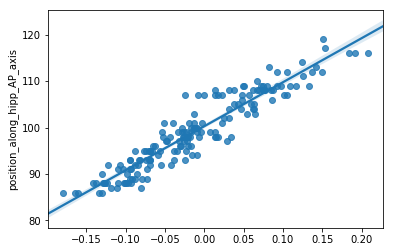

(0.9424780132848118, 7.2779027890288e-82)


In [18]:
# Sanity check
rs = []
for i,samp in enumerate(xp.columns):
    svec = xp[samp]
    refvec = pcalr_out_NEW['betas']
    r,p = stats.pearsonr(svec,refvec)
    rs.append(r)
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(stats.pearsonr(np.array(rs),df.position_along_hipp_AP_axis))

## Associations between HAGS Index and sample X, Y and Z coordinate

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


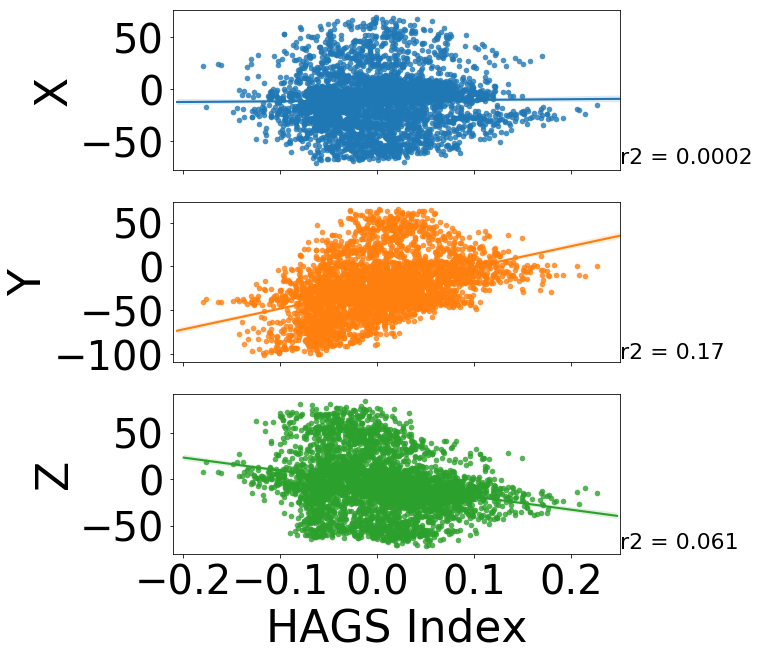

In [20]:
sns.set_context('paper',font_scale=5)
gcx_SPCR = gdf.AP_axis_gxp_signature_similarity_SPCR.values
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_z, ax=ax3)
plt.xlabel('HAGS Index')
#ax1.set(ylabel='MNI X\nCoordinate')
ax1.set(ylabel='X')
ax1.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax1.set(xlim=(-0.21, 0.25))
ax1.set(xticklabels=['','','','',''])
#ax2.set(ylabel='MNI Y\nCoordinate')
ax2.set(ylabel='Y')
ax2.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax2.set(xlim=(-0.21, 0.25))
ax2.set(yticks=[-100,-50,0,50])
ax2.set(xticklabels=['','','','',''])
#ax3.set(ylabel='MNI Z\nCoordinate')
ax3.set(ylabel='Z')
ax3.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax3.set(xlim=(-0.21, 0.25))

xr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_x)[0]**2
yr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_y)[0]**2
zr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_z)[0]**2
#plt.text(0.11, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 130,'r2 = %s'%float('%.2g'%yr), fontsize=22)
plt.text(0.25, -75,'r2 = %s'%float('%.2g'%zr), fontsize=22)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/XYZ_plots_revised.pdf',
#           bbox_inches='tight')
plt.show()


In [196]:
gdf.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR

In [207]:
#gdf.drop(gdf.columns[16:27],axis=1,inplace=True)

In [38]:
#gdf.to_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'),index=False)

## Plot the HAGS index across the whole brain

In [23]:
mni = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
vec = gdf.AP_axis_gxp_signature_similarity_SPCR.values
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'test'
gcx_img = hap.make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)

In [26]:
from nilearn import plotting
plotting.view_img('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/test_xp_image.nii.gz')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Resting-state analysis

Here, we try to figure out the best Y-coordinate to split the hippocampus into anterior and posterior divisions. We do this splitting the hippocampus along its axis, and then trying to "predict" if a sample is posterior or anterior based on gene expression information. The locations with the best prediction might make for a sensible split.

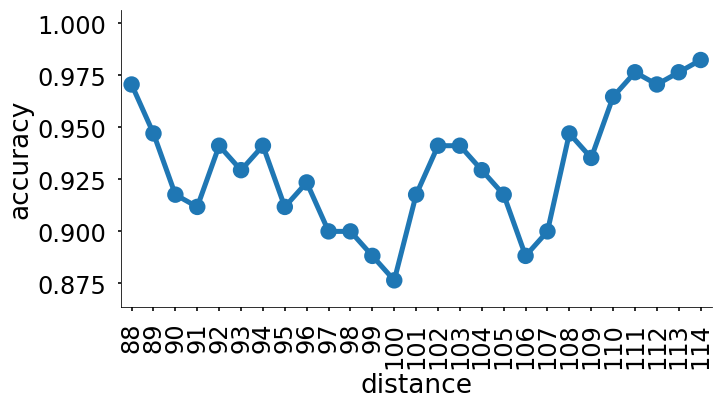

In [232]:
# Results spreadsheet
d_classifiers = pandas.DataFrame(index = range(88,115), columns = ['accuracy'])

# For y-coordinate between 88 and 115...
for i in range(88,115):
    # separate hippocampal tissue samples into "anterior" and "posterior"
    # based on orientation to i
    classes = [0 if x < i else 1 for x in df.position_along_hipp_AP_axis]
    # Run a logistic regression to try to predict split
    tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
    scr = tmod.score(np.array(rs).reshape(-1,1),classes)
    d_classifiers.loc[i,'accuracy'] = scr
d_classifiers.loc[:,'distance'] = d_classifiers.index

# PLOT
plt.close()
sns.set_context('poster', font_scale=1.5)
g = sns.factorplot(x='distance', y='accuracy', data=d_classifiers, size=6, aspect=1.8)
g.set_xticklabels(rotation=90)
plt.plot([94, 94], [0.87, 1], 'r--', linewidth=2)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/fmri_cutpoints.pdf',
#           bbox_inches='tight')
plt.show()

In [28]:
# Get all the connectivity maps from each hippocampal coordinate
cx_scans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*.nii.gz'))

# Get the coordinates of each
scoords = [[int(x[-3]),int(x[-2]),int(x[-1].split('.')[0])
           ] for x in [y.split('_') for y in cx_scans]]

# Find the tissue sample that is closest to the coordinate
for i,row in df.iterrows():
    c = [row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']]
    dists = [(abs(c[0] - sc[0]) + abs(c[1] - sc[1]) + abs(c[2] - sc[2])) for sc in scoords]
    gcx = np.argmin(dists)
    df.loc[i,'closest_cx_map'] = cx_scans[gcx]


#### Make some brain masks using the DKT and Harvard-Oxford atlases

In [11]:
#Load the atlases

#dkt = ni.load('/Users/jakevogel/Science/tau/dkt_atlas_1mm.nii.gz').get_data()
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii.gz').get_data()
HO = ni.load(
        '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
            ).get_data()
#HO = ni.load(
#        '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
#            ).get_data()

#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

#### Relationship between hippocampus connectivity and HAGS index

The following pipeline will:
* Create and average anterior and posterior hippocampus connectivity map, respectively, using input cut points, connectivity maps and coordinates.
* Use these to make a subtraction map representing relative anterior > posterior hippocampus connectivity to the rest of the brain
* Plot the relationship between a sample's HAGS index and its relative connectivity to the anterior vs. posterior hippocampus 

In [35]:
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk3
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
#in_imgs = ['/Users/jakevogel/Science/AHBA/ant_img.nii.gz',
#          '/Users/jakevogel/Science/AHBA/post_img.nii.gz']
hap.run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = in_imgs, bootstrap = False, hue_vals=[],
                                  return_results=True)

FileNotFoundError: No such file or no access: '/Users/jakevogel/Science/AHBA/post_img.nii.gz'

#### Repeat across different anterior/posterior cut coordinates, brainmasks, and extraction window sizes

In [37]:
## THIS WILL TAKE A LONG TIME TO RUN

# Initialize some stuff

dmin = min(df.position_along_hipp_AP_axis)+1
dmax = max(df.position_along_hipp_AP_axis)-4
drange = int((dmax-dmin)/2)
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(drange*len(msks)*len(vrad)),
                                      columns = ['ant_cut','post_cut','n_ant','n_post',
                                                 'mask','vs','r2','p', 'manual_FDR',
                                                 'chance_r2', 'ci_l', 'ci_u'])
cnt = 0
# For each set of cut points
for i in range(drange+1):
    # ID cut points
    ant_cut = dmin+i
    post_cut = dmax-i
    n_ant = len(df[df.position_along_hipp_AP_axis<dmin+i])
    n_post = len(df[df.position_along_hipp_AP_axis>dmax-i])
    # Store cut point and number of anterior and posterior samples
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'ant_cut'] = [ant_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'post_cut'] = [post_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_ant'] = [n_ant] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_post'] = [n_post] * len(msks)*len(vrad)
    # Initialize some variables relating to the rsfmri pipeline
    ycol = 'position_along_hipp_AP_axis'
    ccol = 'closest_cx_map'
    gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
             ccol,'ant > post hippocampal \nfunctional connectivity']
    # For each brainmask
    for m,msk in enumerate(msks):
        # Store mask
        lab = 'msk%s'%(m+1)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
        # Run rsfmri analysis, including permutation tests
        res = hap.run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                       ccol, wdir, gdf, msk, gcx_col, plabs,
                                       del_img = True, diff_img = True,  vrad = vrad,
                                      in_imgs = [], bootstrap = 'bootstrap', hue_vals=[],
                                      return_results=True, illustrative=False, n_iter = 100)
        # Store results
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],
                  ['r2','p','manual_FDR','chance_r2', 'ci_l', 'ci_u']] = res.values
        cnt+=len(vrad)
        # Save results after each iteration
        #resdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_cx_analysis_bootstrap.csv')

In [261]:
#resdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/hipp_cx_analysis_permute.csv',
#                       index_col=0)

In [274]:
resdf.head()

,ant_cut,post_cut,n_ant,n_post,mask,Voxel Radius,r2,p,manual_FDR,chance_r2,ci_l,ci_u,Split,Split ID
0,87,115,5,5,Whole Brain,1,0.186267,3.153058e-154,0.0,0.000283,1.014456e-06,0.001045,87\n115,0
1,87,115,5,5,Whole Brain,2,0.189239,6.267558e-157,0.0,0.000290,1.489335e-06,0.001190,87\n115,0
2,87,115,5,5,Whole Brain,3,0.193634,6.088995e-161,0.0,0.000302,1.191315e-06,0.001166,87\n115,0
3,87,115,5,5,Whole Brain,4,0.199146,5.244619e-166,0.0,0.000286,1.435880e-06,0.001059,87\n115,0
4,87,115,5,5,Whole Brain,5,0.205578,5.838083e-172,0.0,0.000311,8.281229e-07,0.001221,87\n115,0


A few steps to prepare plot...

In [264]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]
resdf.loc[:,'Split'] = [
        '%s\n%s'%(resdf.loc[x,'ant_cut'],resdf.loc[x,'post_cut']) for x in range(len(resdf))]
resdf.columns = resdf.columns[:5].tolist() + ['Voxel Radius'] + resdf.columns[6:].tolist()


In [266]:
split_tix = [resdf.Split.unique()[x] for x in range(0,len(resdf.Split.unique()),3)]
split_dict = dict(zip(resdf.Split.unique(),range(len(resdf.Split.unique()))))
resdf.loc[:,'Split ID'] = [split_dict[x] for x in resdf.Split]

Aaaaaand plot it

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


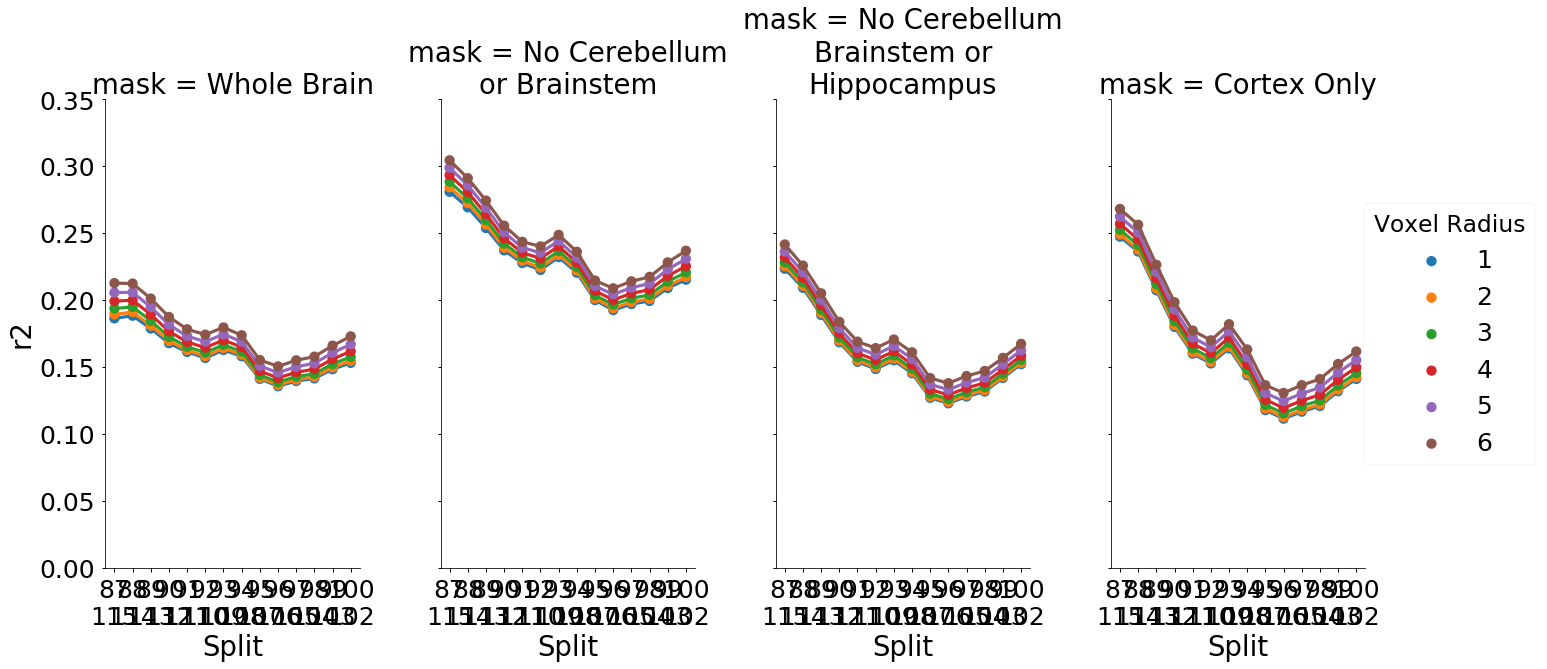

In [284]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='r2', hue='Voxel Radius', col='mask', 
               data=resdf, size=10, aspect=.5)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
plt.ylim(0,0.35)
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


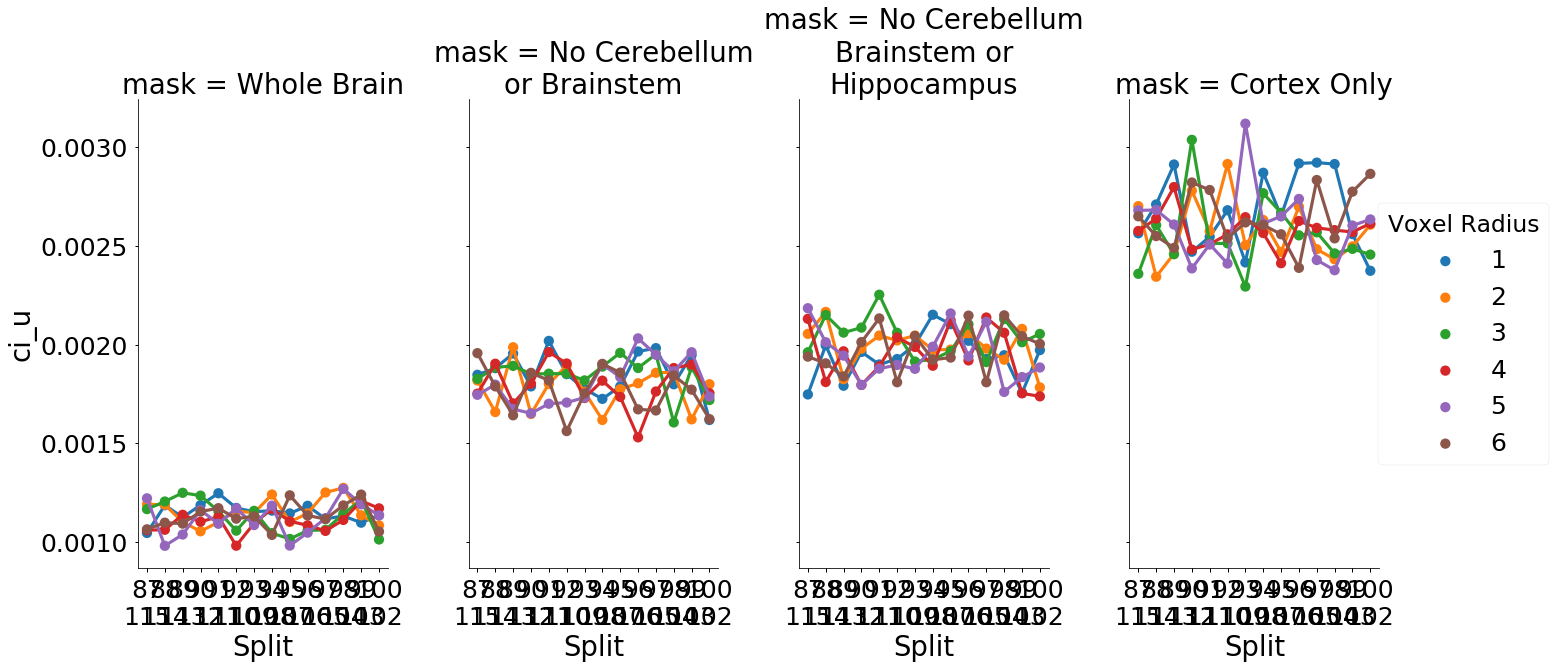

In [288]:
# COMPARED TO THE RANDOM PERMUTATIONS... (plotting the upper 95% confidence interval here...)

sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='ci_u', hue='Voxel Radius', col='mask', data=resdf, size=10, aspect=.5)
#plt.fill(resdf.ci_l, resdf.ci_u)
#plt.ylim(0,0.3)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
plt.show()

#### Number of samples across splits

In [196]:
jnk = pandas.concat([resdf[['Split','n_ant']],
                    resdf[['Split','n_post']]])
jnk.index = range(len(jnk.index))
jnk.columns = ['Split', 'n', 'Structure']
jnk.loc[jnk.index[len(resdf):],'n'] = resdf.n_post.values
jnk.loc[:,'Structure'] = (['Posterior'] * len(resdf)) + (['Anterior'] * len(resdf)) 

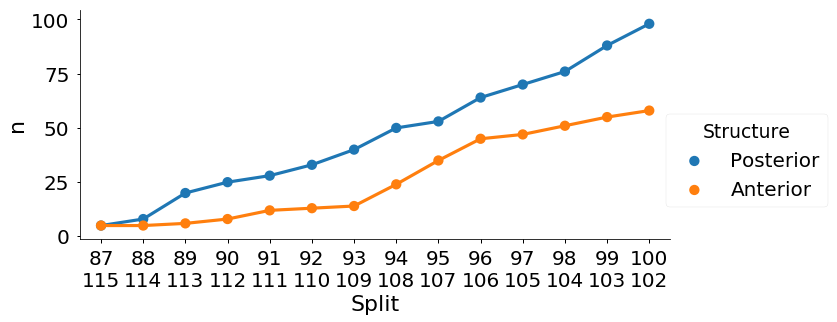

In [203]:
sns.set_context('notebook',font_scale=2)
plt.close()
sns.factorplot(x='Split', y='n', hue= 'Structure', data=jnk, size=5, aspect=2)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_n.pdf',
#           bbox_inches = 'tight')
plt.show()

# FDG Analysis

Initially, running the analysis in native (1.5 mm) space

In [36]:
# Load HAGS map and FTD > AD tmap
gcx = ni.load('r1p5mm_MAIN_SPCR_nlin_xp_image.nii.gz').get_data()
tmap_GN = ni.load('maps/AD-FTD_globalnorm2.nii.gz').get_data()

FileNotFoundError: No such file or no access: 'r1p5mm_MAIN_SPCR_nlin_xp_image.nii.gz'

Load some masks in 1.5mm space

In [249]:
dkt = ni.load('from_ron/dkt_atlas_1p5mm.nii').get_data()
#dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii').get_data()
#HO = ni.load(
#        '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
#            ).get_data()
HO = ni.load(
        'from_ron/whole_brain_mask.nii.gz'
            ).get_data()
#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

Here, we are plotting the relationship between a sample's HAGS index and its relative vulnerability to FTD over AD, using 4 different brain masks

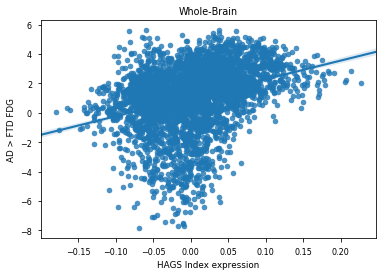

standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89


KeyboardInterrupt: 

In [305]:
msks = [msk1,msk2,msk3,msk4,dkt]
sns.set_context('paper')

img = tmap_GN
vrad=3
vdim = 1.5
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Whole-Brain',
         'HAGS Index expression','AD > FTD FDG']
for mask in msks:
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                           bootstrap, n_iter=10, hue_vals=[], illustrative=True)

And here, we repeat the analysis, vary the size of the extraction window, and store the results

In [36]:
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(len(msks)*len(vrad)),
                                      columns = ['mask','vs','r2','p'])
cnt = 0
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
for m,mask in enumerate(msks):
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    lab = 'msk%s'%(m+1)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
    res = hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                               bootstrap=False, n_iter=10, hue_vals=[], illustrative=False)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],['r2','p',]] = res.values
    cnt+=len(vrad)
    resdf.to_csv('/Users/jakevogel/Science/AHBA/AD_FTD_HAGS_analysis')

standard statistics: r2 = 0.0953458118362, p = 2.40805102453e-82
standard statistics: r2 = 0.0987310577193, p = 2.35366292708e-85
standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89
standard statistics: r2 = 0.107440966081, p = 3.77132286294e-93
standard statistics: r2 = 0.111510464226, p = 8.10583202345e-97
standard statistics: r2 = 0.115522956538, p = 1.88934368964e-100
standard statistics: r2 = 0.107289522824, p = 7.60550124135e-55
standard statistics: r2 = 0.110074531871, p = 2.63578543817e-56
standard statistics: r2 = 0.114258310502, p = 1.65567337855e-58
standard statistics: r2 = 0.119180530404, p = 4.12528786146e-61
standard statistics: r2 = 0.124208161569, p = 8.74066636048e-64
standard statistics: r2 = 0.129603678308, p = 1.13577976502e-66
standard statistics: r2 = 0.107114960594, p = 6.53415997944e-50
standard statistics: r2 = 0.11002259916, p = 2.68962016552e-51
standard statistics: r2 = 0.114553175964, p = 1.82869567753e-53
standard statistics: r2 = 0.1200387753

And then plot it

In [38]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]
resdf.columns = ['Mask','Voxel Radius'] + resdf.columns[2:].tolist()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


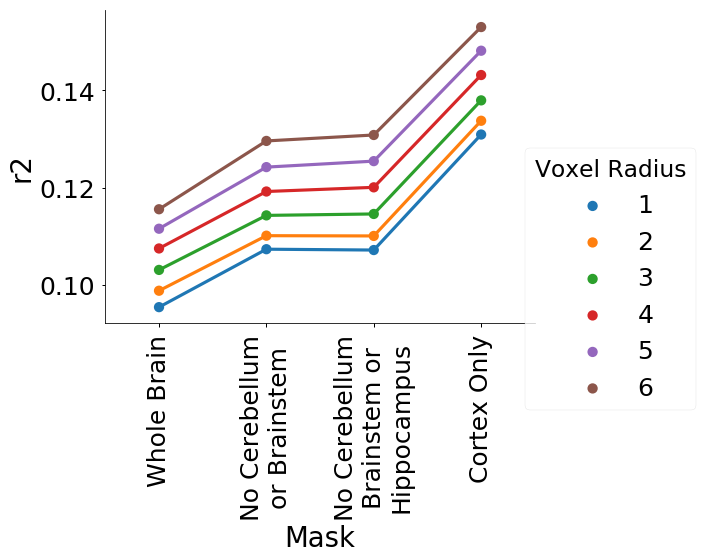

In [51]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
f = sns.factorplot(x='Mask', y='r2', hue='Voxel Radius', data=resdf, size=7, aspect=1.2)
f.set_xticklabels(rotation=90)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/AD_FTD_control_analysis.pdf',
           bbox_inches = 'tight')
plt.show()

Here's what we end up using for the paper?

In [78]:
msk = msk3
vrad = 3
bootstrap = 'False'
hue_vals = []
return_results = True
illustrative = True
if type(vrad) != list:
    vrad = [vrad]
res = pandas.DataFrame(index=vrad,columns=['r2','p'])
for vs in vrad:
    g_cx = []
    f_cx = []
    if len(hue_vals) > 0:
        hvs = []

    for i,row in gdf.iterrows():
        #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                               'xyz', 1.5)
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vs)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])
            if len(hue_vals) > 0:
                hvs.append(hue_vals[i])


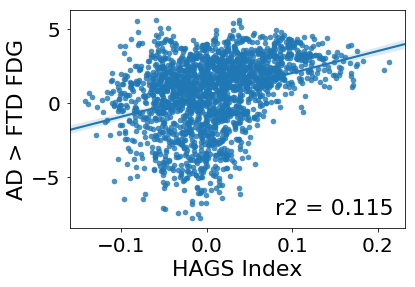

In [84]:

plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(np.array(g_cx), np.array(f_cx))
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel(plabs[2])
r2 = stats.pearsonr(np.array(g_cx), np.array(f_cx))[0]**2
plt.text(0.08, -7.5,'r2 = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/FDG_HAGS.pdf',
            bbox_inches = 'tight')
plt.show()


# Structural covariance

Get OASIS VBM data...

In [15]:
from nilearn import datasets, image, plotting, input_data

In [16]:
data = datasets.fetch_oasis_vbm()

/home/users/jvogel/.local/lib/python3.6/site-packages/numpy/lib/npyio.py:2278: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [17]:
data.keys()

dict_keys(['gray_matter_maps', 'white_matter_maps', 'ext_vars', 'data_usage_agreement', 'description'])

In [18]:
demos = pandas.DataFrame(data.ext_vars)
demos.head()

,id,mf,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay
0,b'OAS1_0001_MR1',b'F',b'R',74,2,3,29,0.0,1344,0.743,1.306,b'N/A'
1,b'OAS1_0002_MR1',b'F',b'R',55,4,1,29,0.0,1147,0.810,1.531,b'N/A'
2,b'OAS1_0003_MR1',b'F',b'R',73,4,3,27,0.5,1454,0.708,1.207,b'N/A'
3,b'OAS1_0004_MR1',b'M',b'R',28,-1,-1,-1,NaN,1588,0.803,1.105,b'N/A'
4,b'OAS1_0005_MR1',b'M',b'R',18,-1,-1,-1,NaN,1737,0.848,1.010,b'N/A'


In [20]:
# Identify how many individuals who are young healthy controls (i.e. younger than 40)
len(demos[demos.age < 40])

153

In [19]:
# Gather the scans
scans = []
for sub in [str(x)[2:-5] for x in demos[demos.age < 40]['id'].values]:
    for scan in data['gray_matter_maps']:
        if sub in scan:
            scans.append(scan)

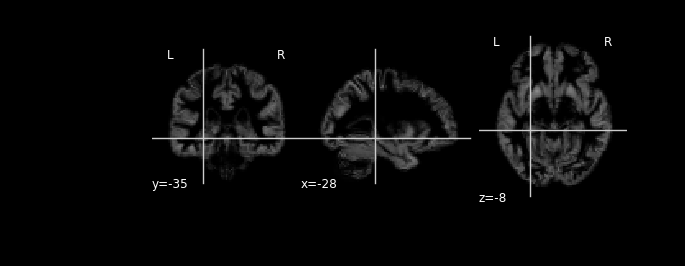

(91, 109, 91)

In [46]:
# Plot one as an example
jnk = ni.load(scans[0])
plt.close()
plotting.plot_anat(jnk, cut_coords=(-28,-35,-8))
plt.show()
jnk.shape

In [30]:
# Load all data into a 4D image
gmvs = image.load_img(scans)
gmvs.shape

(91, 109, 91, 153)

In [31]:
i4d = gmvs.get_data()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


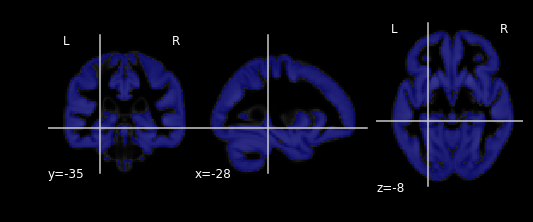

In [32]:
# Make a gray mater mask

avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask[avg_image>0.2] = 1

plt.close()
plotting.plot_roi(ni.Nifti1Image(mask,gmvs.affine),
                  bg_img = ni.Nifti1Image(avg_image,gmvs.affine),
                  cut_coords=(-28,-35,-8))
plt.show()

In [51]:
# Run structural connectivity anlysis
out_imgs = structural_connectivity_analysis(gmvs, df, 'position_along_hipp_AP_axis', 108, 94, 2,
                                           outdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/')

# Diffusion Embedding: Structural

In [33]:
# ALL COORDINATES FOR DIFFUSION EMBEDDING
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(gmvs)
cdf = df[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
all_mtx = get_structural_connectivity(cdf, i4d, i2d, vdim=2, embedded=False)

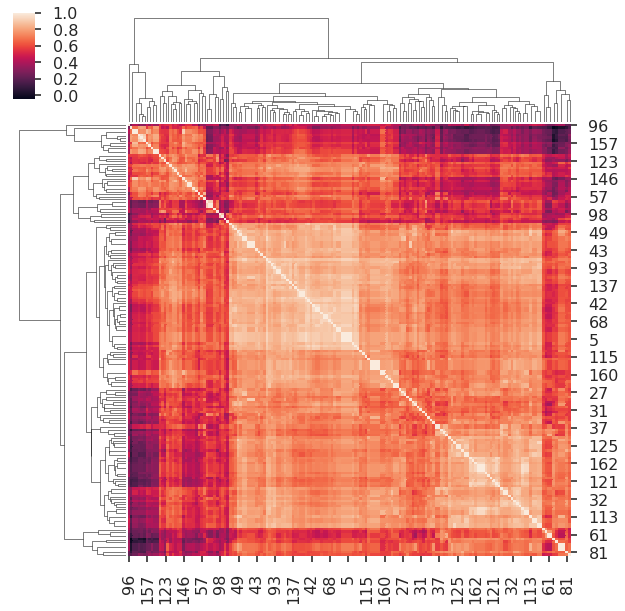

In [143]:
plt.close()
sns.clustermap(jnk)
plt.show()

In [144]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix', all_mtx)

In [6]:
all_mtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix.npz')['arr_0']

#### VISUALIZE RESULTS OF DIFFUSION EMBEDDING

In [145]:
jnk = {'all_mtx': all_mtx}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix',jnk)

In [7]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')

In [57]:
del(all_mtx)

In [58]:
del(gmvs)
del(i4d)
del(i2d)

In [8]:
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
df.loc[:,'predicted'] = predicted

In [60]:
# VARIANCE EXPLAINED:
lambdas = res['res'][0][0][1]
lambdas / np.sum(lambdas)

array([[0.22396729, 0.14395641, 0.13441753, 0.10896485, 0.07861001,
        0.06185049, 0.05669524, 0.0454259 , 0.04152334, 0.03770886,
        0.03393468, 0.03294539]])

In [61]:
svecs = res['res'][0][0][4]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,i]))

0 (-6.843036429089219e-05, 0.9992933616050114)
1 (-0.6618368295623529, 8.723749447165814e-23)
2 (0.173577943025643, 0.0235929687507773)
3 (0.029274894606394614, 0.7047153185536786)
4 (-0.1972507530525155, 0.009930442129227017)
5 (-0.16589345048617823, 0.030615763979139104)
6 (-0.18670636449686484, 0.01477412795284198)
7 (0.21740870703572462, 0.004400954851890191)
8 (-0.22910158729275748, 0.0026544569949718696)
9 (0.07729665669249074, 0.31639707023572244)
10 (0.03760419328106904, 0.6263621131001496)
11 (-0.09852864139144457, 0.20114686824337744)
12 (-0.009592176644130482, 0.9011990422302446)


In [63]:
svecs = res['res'][0][0][4]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.predicted, svecs[:,i]))

0 (-0.04288758480072692, 0.5786787701147353)
1 (-0.6425489351674218, 3.555532833943468e-21)
2 (0.11972310096982958, 0.11992701546597838)
3 (0.010638504479555281, 0.8904857114293425)
4 (-0.18573276344674836, 0.015311341629481917)
5 (-0.1302638910441913, 0.09043180038625706)
6 (-0.16232542831012178, 0.03443875495970426)
7 (0.22671194361020078, 0.0029494030513440026)
8 (-0.26723436122548055, 0.00042686306707129425)
9 (0.0460475693734612, 0.5509924295159598)
10 (0.05770220764714501, 0.4548118721367108)
11 (-0.09973679074694292, 0.19565043809818783)
12 (0.026405193477227553, 0.732500562749499)


In [1089]:
#df.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_ALLVAR_hippocampus_sample_info.csv')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


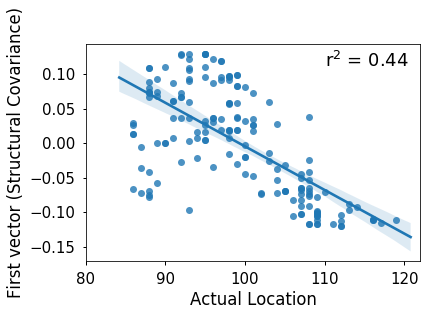

In [65]:
sns.set_context('notebook', font_scale=1.5)

plt.close()
sns.regplot(df.position_along_hipp_AP_axis, svecs[:,1])
plt.xlabel('Actual Location')
plt.ylabel('First vector (Structural Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,1])
plt.text(110,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_actual.pdf',
#           bbox_inches='tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


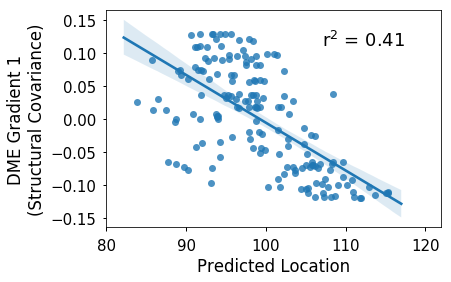

In [69]:
plt.close()
sns.regplot(predicted, svecs[:,1])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 1\n(Structural Covariance)')
r,p = stats.pearsonr(predicted, svecs[:,1])
plt.text(107,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_predicted.pdf',
#           bbox_inches='tight')
plt.show()

In [59]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')
svecsCTX = emb['emb']
#dme_ress = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])
dme_ress = pandas.DataFrame(index=range(svecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(svecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecsCTX[:,i])
    dme_ress.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(predicted, svecsCTX[:,i])
    dme_ress.loc[i,'predicted_r2'] = r**2
    dme_ress.loc[i,'predicted_p'] = p

# p-correction
dme_ress.loc[:,'p(corrected)'] = multipletests(dme_ress.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_ress.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

#dme_ress.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_S_table.csv')
dme_ress

ValueError: operands could not be broadcast together with shapes (170,) (332,) 

## Diffusion Embedding: Functional

In [22]:
cx_paths = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*'))
cx_coords = []
for i,cx in enumerate(cx_paths):
    cx_X = int(cx.split('_')[-3])
    cx_Y = int(cx.split('_')[-2])
    cx_Z = int(cx.split('_')[-1].split('.')[0])
    cx_coords.append([cx_X, cx_Y, cx_Z])
    

In [73]:
len(cx_coords)

96

In [23]:
coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

In [24]:
samp2func_mapping = {}
for i in df.index: 
    coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values
    dists = []
    for cc in cx_coords:
        dist = sum([abs(cc[0] - coords[0]), 
                    abs(cc[1] - coords[1]), 
                    abs(cc[2] - coords[2])])
        dists.append(dist)
    gind = np.argmin(dists)
    samp2func_mapping.update({i: gind})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


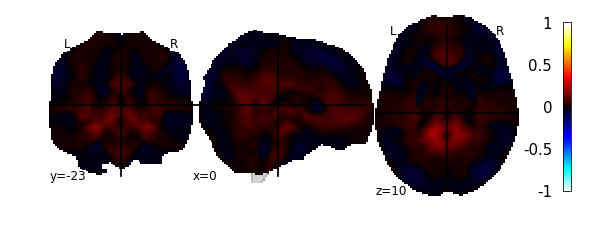

In [77]:
plt.close()
plotting.plot_stat_map(cx_paths[0])
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


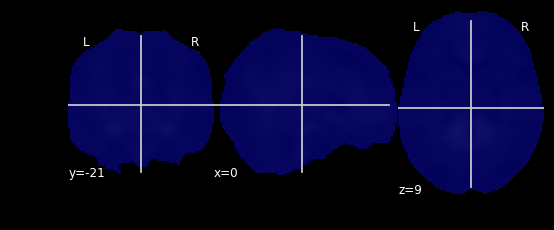

In [78]:
jnk = ni.load(cx_paths[0])
dat = jnk.get_data()
dat[dat!=0] = 1
mask = ni.Nifti1Image(dat, jnk.affine)
plt.close()
plotting.plot_roi(mask,cx_paths[0])
plt.show()

In [79]:
maskr = input_data.NiftiMasker(mask_img=mask)
mjnk = maskr.fit_transform(jnk)
mjnk.shape

(1, 280494)

In [14]:
# MASKS TAKEN FROM GET CX VECTOR SECTION BELOW
mni2mm = ni.load('/usr/share/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz')

mskrs = {}
for i, msk in enumerate([msk1, msk2, msk3, msk4]):
    l = i+1
    arr = np.zeros_like(msk)
    arr[msk.astype(int)>0] = 1
    jnk = ni.Nifti1Image(arr.astype(int), mni2mm.affine)
    mskr = input_data.NiftiMasker(jnk)
    mskrs.update({'msk%s'%l: mskr})

In [55]:
n_feats = len([x for x in mskrs['msk4'].mask_img.get_data().flat>0 if x])
i2d = np.zeros((len(df.index),n_feats))
for samp, pth in samp2func_mapping.items():
    i2d[samp,:] = mskrs['msk4'].fit_transform(cx_paths[pth])[0,:]
    print(samp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


In [56]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX', i2d)
jnk = {'all_mtx': i2d}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX',jnk)

In [61]:
from statsmodels.sandbox.stats.multicomp import multipletests
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_res.mat')
fvecsCTX = emb['emb']
dme_resf = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(fvecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,i])
    dme_resf.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(predicted, fvecsCTX[:,i])
    dme_resf.loc[i,'predicted_r2'] = r**2
    dme_resf.loc[i,'predicted_p'] = p

# p-correction
dme_resf.loc[:,'p(corrected)'] = multipletests(dme_resf.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_resf.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

dme_resf

,position_r2,predicted_r2,predicted_p,p(corrected),Expl. Var of Gradient
0,0.033716,0.0318459,0.0198954,0.198954,0.178543
1,0.207215,0.209002,3.68212e-10,3.68212e-09,0.157541
2,0.459425,0.398209,2.87252e-20,2.87252e-19,0.135064
3,0.0304687,0.015419,0.106674,1,0.118252
4,0.00845761,0.000657191,0.740012,1,0.091784
5,0.0748605,0.0619135,0.00106808,0.0106808,0.086254
6,0.000557226,0.00621349,0.30689,1,0.078544
7,0.00253061,5.46604e-07,0.992366,1,0.063419
8,0.0351465,0.038701,0.0101335,0.101335,0.050019
9,0.0446761,0.0399738,0.00894785,0.0894785,0.040582


In [1131]:
#dme_resf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_F_table.csv')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


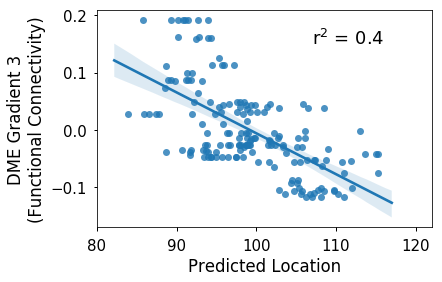

In [110]:
plt.close()
sns.regplot(predicted, fvecsCTX[:,2])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 3\n(Functional Connectivity)')
r,p = stats.pearsonr(predicted, fvecsCTX[:,2])
plt.text(107,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_predicted_CTX.pdf',
#           bbox_inches='tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


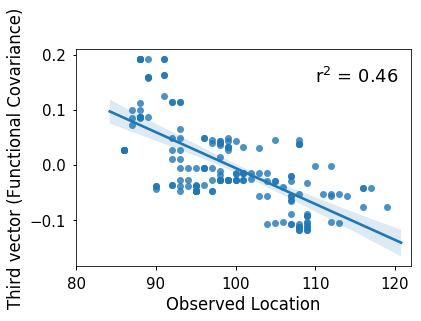

In [111]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis, fvecsCTX[:,2])
plt.xlabel('Observed Location')
plt.ylabel('Third vector (Functional Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,2])
plt.text(110,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_observed_CTX.pdf',
#           bbox_inches='tight')
plt.show()

# NEED TO PUT IN STUFF HERE

In [120]:
df.loc[:,'Set 1'] = MOD_t100['final_model'].predict(top_100.values.T)
df.loc[:,'Set 2'] = MOD_t100_600['final_model'].predict(PCA_t100_600)
df.loc[:,'Set 1,2'] = MOD_t600['final_model'].predict(PCA_600)
df.loc[:,'Set 3'] = MOD_t600_2700['final_model'].predict(PCA_t600_2700)
df.loc[:,'Set 1,2,3'] = MOD_t2700['final_model'].predict(PCA_t2700)

df.columns = df.columns[:-6].tolist() + ['All 58k','Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3' ]
dme_res = pandas.DataFrame(index = range(2*6),
                           columns = ['modality','set','r2'])
c = 0
gsets = [top_100, top_100_600, top_600, top_600_2700, top_2700]
for l,col in enumerate(df.columns[-6:]):
    if l == 0:
        predicted = df[col].values
    else:
        gset = gsets[l-1]
        if col == 'Set 1':
            pcalr_res = PCA_LR_pipeline(gset.values.T,
                                        (df.position_along_hipp_AP_axis), pca=None,
                                        clf = linear_model.LassoCV(cv=10,max_iter=5000),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(gset.values.T)
        else:
            pcalr_res = PCA_LR_pipeline(gset.values.T, 
                                        (df.position_along_hipp_AP_axis),
                                        clf = linear_model.LassoCV(cv=10),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(pcalr_res['pca_object'].transform(gset.values.T))
        df[col] = predicted
    for i,vec in enumerate([svecs, fvecsCTX]):
        if i == 0:
            lab = 'Structural Covariance'
            ind = 1
        else:
            lab = 'Functional Connectivity'
            ind=3
        r,p = stats.pearsonr(df[col], vec[:,ind])
        dme_res.loc[c,'modality'] = lab
        dme_res.loc[c,'set'] = col
        dme_res.loc[c,'r2'] = r**2
        c+=1


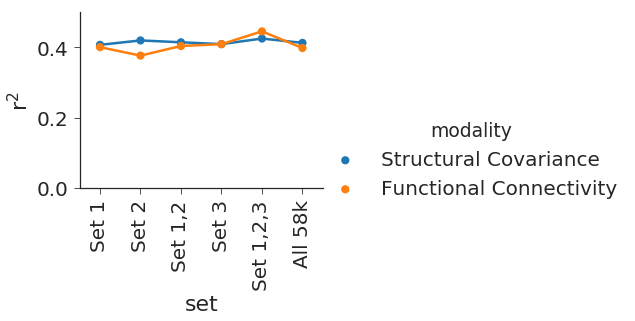

In [522]:
sns.set_context('paper', font_scale=2.5)
plt.close()
g = sns.factorplot(x='set',y='r2',hue='modality',data=dme_res, aspect=1.5,
                   order=['Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3', 'All 58k'])
g.set_xticklabels(rotation=90)
plt.ylabel('r$^2$')
plt.ylim(0,0.5)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_Set_comp.pdf',
           bbox_inches='tight')
plt.show()

### Visualize DME Gradients

#### functional

In [5]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_res.mat')

In [62]:
fmtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX.npz'
       )['arr_0']

>>>GRADIENT 2 <<<<


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


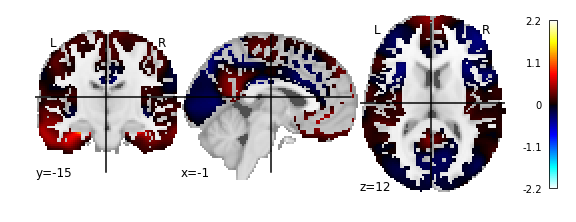

>>>GRADIENT 3 <<<<


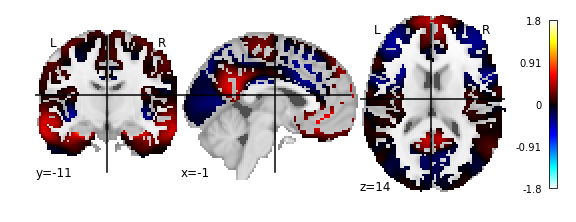

>>>GRADIENT 6 <<<<


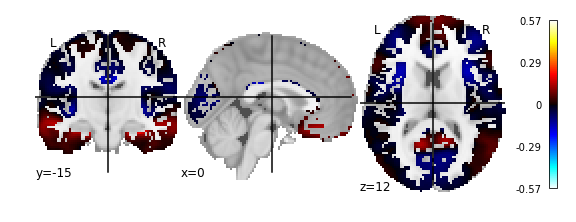

In [79]:
dmskr = mskrs['msk4'].fit(cx_paths[pth]) # initiate mask

for i in range(emb['emb'].shape[-1]): # for each gradient
    # if gradient significantly associqated with genomic gradient
    if dme_resf.loc[i,'p(corrected)'] < 0.05:
        print('>>>GRADIENT %s <<<<'%(i+1))
        dmat = np.dot(fmtx.T, emb['emb'][:,i]) # get voxelwise weights
        dmat = dmat.reshape(1,len(dmat)) # convert to transformable shape
        dmat_i = dmskr.inverse_transform(dmat).get_data() # transform to image spaace
        # reverse the sign of Gradient 3:
        if i == 2:
            dmat_i *= -1
        dmat_i = dmat_i.reshape(dmat_i.shape[:3]) # reshape back to 3D space
        dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine) # make back into nii object
        # plot
        plt.close()
        plotting.plot_stat_map(dmat_img)
        plt.show()
        # save
        dmat_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_FUNC_CTX_Gradient%s'%i)

In [75]:
dmat = np.dot(fmtx.T, emb['emb'][:,3])

In [76]:
dmat = dmat.reshape(1,len(dmat))

In [80]:
dmskr = mskrs['msk4'].fit(cx_paths[pth])
dmat_i = dmskr.inverse_transform(dmat).get_data()
dmat_i = dmat_i.reshape(dmat_i.shape[:3])
dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine)

In [81]:
#plotting.view_img(dmat_img)

#### Structural

In [25]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')

In [26]:
smtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix.npz')['arr_0']

In [28]:
dmat.shape

(1, 148661)

>>>GRADIENT 1 <<<<


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


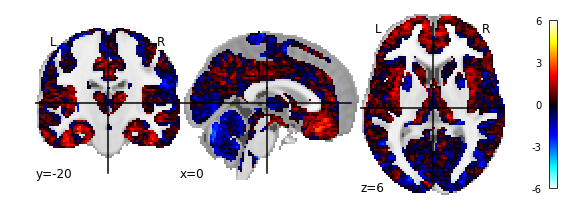

>>>GRADIENT 7 <<<<


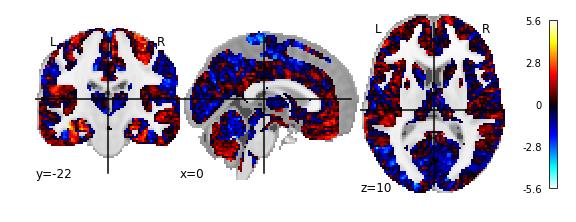

>>>GRADIENT 8 <<<<


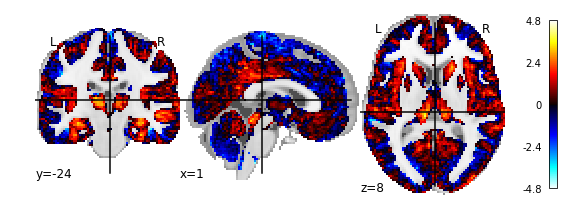

In [58]:
dmskr = mskr.fit(ni.load(scans[0])) # initiate mask

for i in range(emb['emb'].shape[-1]): # for each gradient
    # if gradient significantly associated with genomic gradient
    if dme_ress.loc[i,'p(corrected)'] < 0.05:
        print('>>>GRADIENT %s <<<<'%(i+1))
        dmat = np.dot(smtx.T, emb['emb'][:,i]) # get voxelwise weights
        dmat = ((dmat - dmat.mean()) / dmat.std()) * -1 # mean center
        # reverse the sign of Gradients 6:
        if i == 6:
            dmat *= -1
        dmat = dmat.reshape(1,len(dmat)) # convert to transformable shape
        dmat_i = dmskr.inverse_transform(dmat).get_data() # transform to image spaace
        dmat_i = dmat_i.reshape(dmat_i.shape[:3]) # reshape back to 3D space
        dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine) # make back into nii object
        # plot
        plt.close()
        plotting.plot_stat_map(dmat_img)
        plt.show()
        # save
        dmat_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_STRUCT_CTX_Gradient%s'%i)

In [50]:
dmat = np.dot(smtx.T, emb['emb'][:,0])

In [51]:
dmat = dmat.reshape(1,len(dmat))
dmat = ((dmat - dmat.mean()) / dmat.std()) * -1

In [52]:
dmat_i = dmskr.inverse_transform(dmat).get_data()
dmat_i = dmat_i.reshape(dmat_i.shape[:3])
dmat_img = ni.Nifti1Image(dmat_i, affine=mni2mm.affine)

In [53]:
plotting.view_img(dmat_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Get all cx vectors --> summaries in the same space

In [61]:
mni2mm = ni.load('/usr/share/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz')
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii.gz')
f_diff = ni.load('/home/users/jvogel/git/Hippocampus_AP_Axis/maps/p_over_a_rsfmri.nii.gz')
d_diff = ni.load('/home/users/jvogel/git/Hippocampus_AP_Axis/maps/AD-FTD_globalnorm2.nii.gz')
s_diff = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_z_difference.nii')
dme_s = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_STRUCT_CTX_Gradient0.nii')
dme_f = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Diffusion_Map_Embedding/DME_FUNC_CTX_Gradient2.nii')
HO2mm = ni.load('/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-2mm.nii.gz').get_data()
diffs = {'fmri':f_diff, 'dis': d_diff, 'struc': s_diff, 'dkt': dkt,
        'dme_s': dme_s, 'dme_f': dme_f}
diffs_2mm = {}
for lab,diff in diffs.items():
    print(lab,diff.shape)
    nimg = image.resample_to_img(diff, mni2mm)
    print('new shape', nimg.shape)
    diffs_2mm.update({lab: nimg})

fmri (182, 218, 182)
new shape (91, 109, 91)
dis (121, 145, 121)
new shape (91, 109, 91)
struc (91, 109, 91, 1)
new shape (91, 109, 91, 1)
dkt (182, 218, 182)
new shape (91, 109, 91)
dme_s (91, 109, 91)
new shape (91, 109, 91)
dme_f (91, 109, 91)
new shape (91, 109, 91)


In [13]:
dkt2 = diffs_2mm['dkt'].get_data()

msk1 = np.array(HO2mm,copy=True)
msk1[HO2mm<1] = 0
#no cereb or brainstem
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt2==36] = 0
msk3[dkt2==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt2>31] = 0
msk4[dkt2>41] = dkt2[dkt2>41]
msk4[dkt2>70] = 0

In [62]:
vectors = {}

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


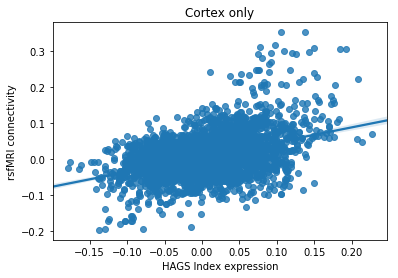

standard statistics: r2 = 0.1697243936148188, p = 9.170724334678806e-143


In [90]:
# functional & genetic

img = diffs_2mm['fmri'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'fcx': vex['cx_vector']})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


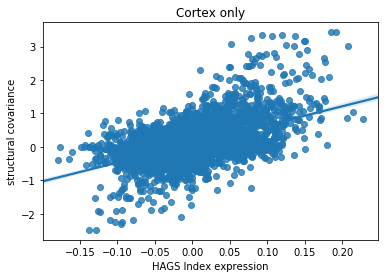

standard statistics: r2 = 0.2667798513356201, p = 8.424429089471122e-237


In [103]:
# structural

img = diffs_2mm['struc'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','structural covariance']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'scx': vex['cx_vector']})

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


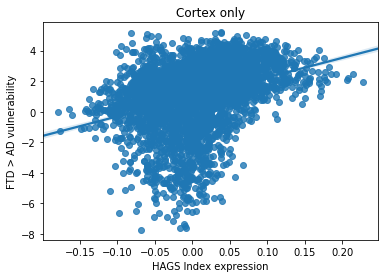

standard statistics: r2 = 0.10958678138429084, p = 7.936230832969252e-90


In [102]:
# disease

img = diffs_2mm['dis'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','FTD > AD vulnerability']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'dcx': vex['cx_vector']})

In [113]:
all_vex = pandas.DataFrame.from_dict(vectors)
all_vex.head()

,dcx,fcx,gcx,scx
0,1.936761,-0.017439,0.017612,0.500187
1,3.481936,0.030193,-0.048591,0.670868
2,3.063823,0.028174,-0.001852,0.744531
3,3.706228,0.032463,0.006891,0.344802
4,2.084073,0.032044,-0.024976,0.308254


#### prepare figures

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


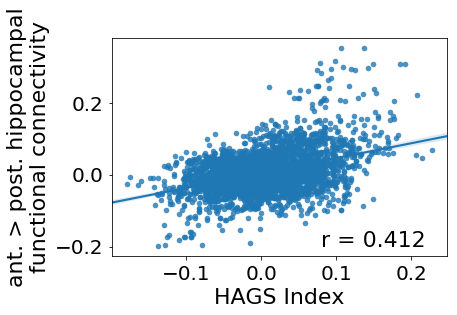

In [119]:
g_cx = all_vex.gcx.values
f_cx = all_vex.fcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, f_cx)
#plt.title(plabs[0])a
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nfunctional connectivity')
#r2 = stats.pearsonr(g_cx,f_cx)[0]**2
#plt.text(0.08, -0.20,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,f_cx)[0]
plt.text(0.08, -0.20,'r = %s'%float('%.3g'%r), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/rsfmri_HAGS_Msk1_r.pdf',
           bbox_inches = 'tight')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


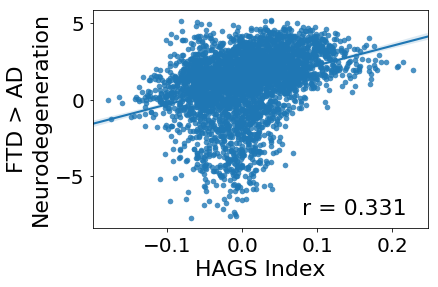

In [120]:
d_cx = all_vex.dcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, d_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('FTD > AD\nNeurodegeneration')
# r2 = stats.pearsonr(g_cx, d_cx)[0]**2
# plt.text(0.08, -7.5,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,d_cx)[0]
plt.text(0.08, -7.5,'r = %s'%float('%.3g'%r), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/FDG_HAGS_Msk1_r.pdf',
            bbox_inches = 'tight')
plt.show()


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


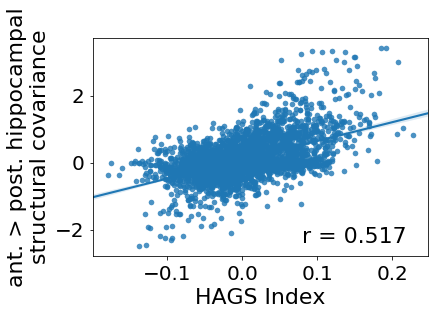

In [121]:
s_cx = all_vex.scx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, s_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nstructural covariance')
# r2 = stats.pearsonr(g_cx, s_cx)[0]**2
# plt.text(0.08, -2.4,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
r = stats.pearsonr(g_cx,s_cx)[0]
plt.text(0.08, -2.4,'r = %s'%float('%.3g'%r), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/scx_HAGS_Msk1_r.pdf',
            bbox_inches = 'tight')
plt.show()


### NEED TO INSERT STUFF HERE

In [565]:
vec100 = get_gene_vector(bigdf,probe_ids=top_100.index, betas=MOD_t100['betas'])
vec1_600 = get_gene_vector(bigdf,probe_ids=top_100_600.index, betas=MOD_t100_600['betas'])
vec600 = get_gene_vector(bigdf, probe_ids=top_600.index,betas=MOD_t600['betas'])
vec6_2700 = get_gene_vector(bigdf,probe_ids=top_600_2700.index, betas=MOD_t600_2700['betas'])
vec2700 = get_gene_vector(bigdf,probe_ids=top_2700.index,betas=MOD_t2700['betas'])
vec5k = get_gene_vector(bigdf,probe_ids=mod_genes[mod_genes.step<5].index)

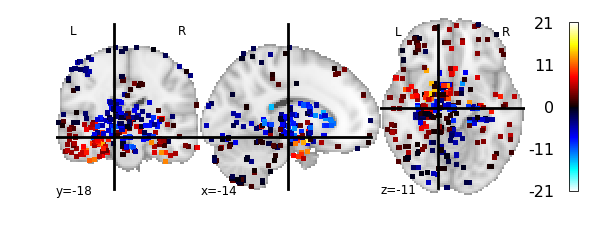

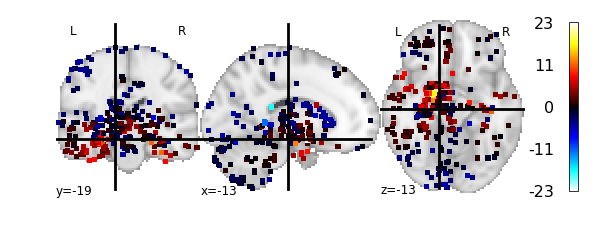

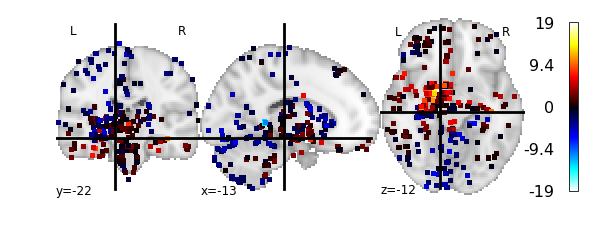

In [383]:
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
vex = {'100': vec100, '600': vec600, '2700': vec2700}
for n_probes,vec in vex.items():
    nm = 'XPIMG_%s_top_probes'%n_probes
    gcx_img = make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)
    plt.close()
    plotting.plot_stat_map(gcx_img)
    plt.show()

In [225]:
diffs_2mm.keys()

dict_keys(['fmri', 'dis', 'struc', 'dkt'])

In [239]:
res['r2'].values[0]

0.11829177782899052

In [257]:
msks = {'Whole brain': msk1, 'No Cereb/Brainstem': msk2, 
        'No Hippocampus': msk3, 'Cortex only': msk4}
imods = ['fmri','dis','struc']
gsets = {'vec100': vec100, 'vec1_600': vec1_600, 'vec600': vec600, 
         'vec6_2700': vec6_2700, 'vec2700': vec2700, 'all': 'all'}
gset_res = pandas.DataFrame(index = range(len(imods) * len(msks.keys()) * len(gsets.keys())),
                            columns = ['modality', 'mask', 'gene_set', 'r2'])
gcx_col='gvec'
vrad = 3
vdim = 2
bootstrap = False
plabs = ['HAGS v Imaging', 'HAGS', 'Imaging']
i=0
for imod in imods:
    img = diffs_2mm[imod].get_data()
    for glab, gset in gsets.items():
        if gset == 'all':
            gdf.loc[:,'gvec'] = gdf.AP_axis_gxp_signature_similarity_SPCR.values
        else:
            gdf.loc[:,'gvec'] = gset
        for mlab, msk in msks.items():
            res, vex = hap.run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=False)
            gset_res.loc[i,'modality'] = imod
            gset_res.loc[i,'gene_set'] = glab
            gset_res.loc[i,'mask'] = mlab
            gset_res.loc[i,'r2'] = res['r2'].values[0]
            i += 1
    print('finished',imod)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


standard statistics: r2 = 0.230920243648, p = 1.09439753179e-200
standard statistics: r2 = 0.236635414488, p = 2.73410886168e-197
standard statistics: r2 = 0.175796090851, p = 1.61935915947e-133
standard statistics: r2 = 0.13790841134, p = 1.35149333997e-87
standard statistics: r2 = 0.19142252048, p = 8.41885763522e-163
standard statistics: r2 = 0.196941442942, p = 1.2242336611e-160
standard statistics: r2 = 0.119913469242, p = 7.10413342607e-89
standard statistics: r2 = 0.104343612156, p = 1.56678145882e-65
standard statistics: r2 = 0.229357380307, p = 3.75582958601e-199
standard statistics: r2 = 0.23389803373, p = 1.05824000688e-194
standard statistics: r2 = 0.156546818233, p = 8.23340603273e-118
standard statistics: r2 = 0.134135098635, p = 4.49587702569e-85
standard statistics: r2 = 0.140331009565, p = 1.96415809314e-116
standard statistics: r2 = 0.142167636837, p = 6.48630917324e-113
standard statistics: r2 = 0.0820390570312, p = 3.57089321844e-60
standard statistics: r2 = 0.07283

In [258]:
nkey = {'vec100': 'Set 1', 'vec1_600': 'Set 2', 'vec600': 'Sets 1,2', 
        'vec6_2700': 'Set 3', 'vec2700': 'Sets 1,2,3', 'all': 'All 58k' }
gset_res.loc[:,'gene_set'] = [nkey[x] for x in gset_res.gene_set.values]

In [259]:
nkey = {'fmri': 'FC', 'struc': 'SC', 'dis': 'Disease'}
gset_res.loc[:,'modality'] = [nkey[x] for x in gset_res.modality]
gset_res.columns = ['analysis' if x == 'modality' else x for x in gset_res.columns]

In [260]:
gset_res.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_geneset_v_img_modality.csv')

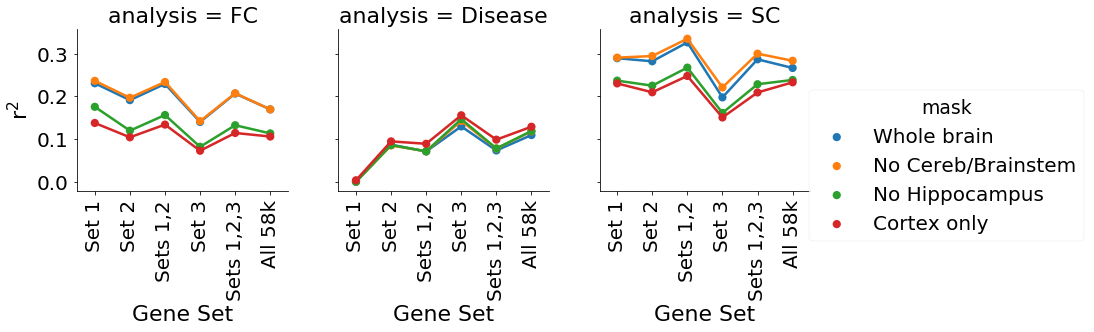

In [265]:
plt.close()
g = sns.factorplot(x = 'gene_set', y = 'r2', hue = 'mask', col = 'analysis', data = gset_res)
g.set_xticklabels(rotation = 90)
g.set_xlabels('Gene Set')
g.set_ylabels('r$^2$')
g.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/GeneSet_v_imaging.pdf')
plt.show()

In [410]:
gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv')